In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, InputSpec
import os
import warnings

# Custom callback to stop training when validation accuracy reaches 100%
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, monitor='val_accuracy', value=1.0, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn(f'Early stopping requires {self.monitor} available!', RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print(f'\nEpoch {epoch + 1}: Validation accuracy reached {self.value * 100:.2f}%, stopping training.')
            self.model.stop_training = True

# Define SE Block
class SEBlock(Layer):
    def __init__(self, reduction=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.reduction = reduction

    def build(self, input_shape):
        self.input_spec = InputSpec(ndim=4)
        self.channels = input_shape[-1]
        self.global_avg_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense2 = Dense(self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)
        super(SEBlock, self).build(input_shape)

    def call(self, inputs):
        se = self.global_avg_pool(inputs)
        se = tf.expand_dims(tf.expand_dims(se, 1), 1)
        se = self.dense1(se)
        se = self.dense2(se)
        return inputs * se

# Dataset path
dataset_dir = "C:/namithaa/s4_proj/robotics/data_set/My_dataset"

target_size = (224, 224)  # Target size for DenseNet121
batch_size = 32

# Define the data generators with increased augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=45,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)

# Data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  
)

# Load DenseNet121 with pre-trained ImageNet weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of DenseNet121
x = base_model.output
x = SEBlock()(x)  
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  
x = Dropout(0.3)(x)  
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tune more layers of DenseNet121
for layer in base_model.layers[:-50]:
    layer.trainable = False  
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile the model
optimizer = Adam(learning_rate=0.0001)  
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
early_stopping_accuracy = EarlyStoppingAtAccuracy(monitor='val_accuracy', value=1.0, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Use len() instead of .samples
    epochs=15,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


Found 3925 images belonging to 3 classes.
Found 979 images belonging to 3 classes.
Epoch 1/15
123/123 [==============================] - 452s 4s/step - loss: 0.5163 - accuracy: 0.8000 - val_loss: 0.4209 - val_accuracy: 0.8417
Epoch 2/15
123/123 [==============================] - 360s 3s/step - loss: 0.2220 - accuracy: 0.9195 - val_loss: 0.4162 - val_accuracy: 0.8590
Epoch 3/15
123/123 [==============================] - 583s 5s/step - loss: 0.1633 - accuracy: 0.9429 - val_loss: 0.3124 - val_accuracy: 0.9030
Epoch 4/15
123/123 [==============================] - 277s 2s/step - loss: 0.1265 - accuracy: 0.9557 - val_loss: 0.3254 - val_accuracy: 0.9050
Epoch 5/15
123/123 [==============================] - 722s 6s/step - loss: 0.1037 - accuracy: 0.9638 - val_loss: 0.2895 - val_accuracy: 0.9111
Epoch 6/15
123/123 [==============================] - 688s 6s/step - loss: 0.0889 - accuracy: 0.9702 - val_loss: 0.2939 - val_accuracy: 0.9101
Epoch 7/15
123/123 [==============================] - 619s 

In [5]:
from tensorflow.keras.models import load_model

# Save the model in HDF5 format
model.save('model.h5')


c:\Users\HP\.conda\envs\mev-kernel\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 125ms/step


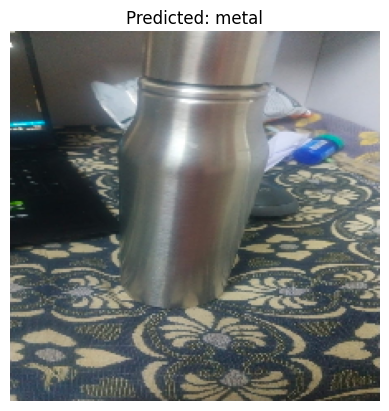

Predicted class: metal


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


# Manually define class labels (update with actual class names)
class_labels = ['metal', 'paper_waste', 'plastic']  # Replace with your actual labels

# Function to predict a new image that is not from the dataset
def predict_new_image(image_path, model, class_labels, target_size=(224, 224)):  
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    # Display the image with predicted class
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    print(f"Predicted class: {predicted_label}")

# Provide the path to a new image (not from your dataset)
new_image_path = r"C:\namithaa\s4_proj\robotics\inp_data\WhatsApp Image 2025-02-04 at 20.26.00_1bfb9ea5.jpg"# Update this with your new image path
predict_new_image(new_image_path, model, class_labels)
